# **Installations**

In [ ]:
#for scan pdf
!pip install -q pypdf PyPDF2 pymupdf
!pip install -q numpy pandas
#for docTR
!pip install python-doctr[viz]
!apt-get install -y poppler-utils
!pip install python-doctr[viz]@git+https://github.com/mindee/doctr.git
!sudo apt-get install fonts-freefont-ttf -y
!pip install opencv-python pillow
!pip install pdf2image
#for open source LLM
!pip install llama-index-llms-huggingface
!pip install -q torch
#for gradio
!pip install -q gradio
!pip install -q gradio_pdf


# Install LlamaIndex packages for enhanced document processing
!pip install -q llama-index
!pip install -q llama-index-readers-file
!pip install -q llama-index-embeddings-huggingface
!pip install -q faiss-cpu
!pip install -q llama-index-vector-stores-faiss
!pip install transformers
!pip install --upgrade llama_index
!pip install llama-index-retrievers-bm25

#getting text summaries
!pip install sumy
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.11).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
  Cloning https://github.com/mindee/doctr.git to /tmp/pip-install-dsmhy5eo/python-doctr_24782cd9ce9b4e529e01540f28eef298
  Running command git clone --filter=blob:none --quiet https://github.com/mindee/doctr.git /tmp/pip-install-dsmhy5eo/python-doctr_24782cd9ce9b4e529e01540f28eef298
  Resolved https://github.com/mindee/doctr.git to commit 07443a04502d3ef7bd4bf4f067305399a090fe29
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-freefont-ttf is already the newest version (20120503-10build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# **Core imports and configuration**

In [ ]:
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
import numpy as np
import fitz  # PyMuPDF
from PyPDF2 import PdfReader
import json
import re
import os
import faiss
import gradio as gr
from gradio_pdf import PDF
from dataclasses import dataclass
from datetime import datetime
import hashlib
import time

#for open_source LLM
from llama_index.core.settings import Settings
from llama_index.core import Document
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core.prompts.prompts import SimpleInputPrompt
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import torch
from transformers import AutoTokenizer, AutoConfig
import pickle

#text summarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

# for sentence splitter-chunking
from llama_index.core.node_parser import SentenceSplitter

#semantic splitter : to form semantically relevant chunks
from llama_index.core.node_parser import SemanticSplitterNodeParser

# LlamaIndex BM25 Retriever
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.schema import TextNode


# =====================================
# Step 1: Mount Google Drive
# =====================================
from google.colab import drive
drive.mount('/content/drive')

# Set your persistent directory inside Google Drive
SAVE_DIR = "/content/drive/MyDrive/phi3_cache"
os.makedirs(SAVE_DIR, exist_ok=True)

LLM_STATE_FILE = f"{SAVE_DIR}/llm_config.pkl"
TOKENIZER_DIR = f"{SAVE_DIR}/tokenizer_cache"
EMBEDDING_FILE = f"{SAVE_DIR}/embeddings.pkl"

# Model names
LLM_MODEL = "microsoft/Phi-3-mini-4k-instruct"
EMBED_MODEL = "intfloat/e5-small-v2"

# =====================================
# Step 3: Helper Function to Save / Load Configs
# =====================================
def save_pickle(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)

def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)
# =====================================
#  Step 4: Initialize or Reload LLM
# =====================================
if os.path.exists(LLM_STATE_FILE):
    print(" Reloading cached Phi-3 LLM config...")
    llm_config = load_pickle(LLM_STATE_FILE)
    llm = HuggingFaceLLM(**llm_config)
else:
    print("⚙️ Initializing Phi-3 Mini LLM for the first time...")
    system_prompt = (
        "You are a precise and reliable assistant specialized in document-based Q&A. "
        "Always base your answers strictly on the provided content and instructions."
    )
    query_wrapper_prompt = "User: {query_str}\nAssistant:"

    llm = HuggingFaceLLM(
        context_window=4096,
        max_new_tokens=128,
        generate_kwargs={"temperature": 0.2, "top_p": 0.9, "do_sample": True},
        system_prompt=system_prompt,
        query_wrapper_prompt=query_wrapper_prompt,
        tokenizer_name=LLM_MODEL,
        model_name=LLM_MODEL,
        device_map="auto",
        model_kwargs={"torch_dtype": torch.float16},
        use_fast_tokenizer=True,
    )

    # Save config to reload instantly next time
    llm_config = {
        "context_window": 4096,
        "max_new_tokens": 128,
        "generate_kwargs": {"temperature": 0.2, "top_p": 0.9, "do_sample": True},
        "system_prompt": system_prompt,
        "query_wrapper_prompt": query_wrapper_prompt,
        "tokenizer_name": LLM_MODEL,
        "model_name": LLM_MODEL,
        "device_map": "auto",
        "model_kwargs": {"torch_dtype": torch.float16},
        "use_fast_tokenizer":True,
        }
    save_pickle(llm_config, LLM_STATE_FILE)
    print("LLM configuration saved to Drive.")

# =====================================
# Step 5: Initialize or Reload Tokenizer
# =====================================
if os.path.exists(TOKENIZER_DIR):
    print(" Reloading tokenizer from Drive...")
    TOKENIZER = AutoTokenizer.from_pretrained(TOKENIZER_DIR)
else:
    print("⚙️ Downloading tokenizer for the first time...")
    TOKENIZER = AutoTokenizer.from_pretrained(LLM_MODEL)
    TOKENIZER.save_pretrained(TOKENIZER_DIR)
    print("Tokenizer saved to Drive.")

# =====================================
# Step 6: Initialize or Reload Embedding Model
# =====================================
if os.path.exists(EMBEDDING_FILE):
    print(" Reloading embedding data from Drive...")
    with open(EMBEDDING_FILE, "rb") as f:
        all_embeddings = pickle.load(f)
else:
    print("⚙️ Initializing embedding model (first time)...")
    all_embeddings = {}
    with open(EMBEDDING_FILE, "wb") as f:
        pickle.dump(all_embeddings, f)
    print("Embedding file initialized in Drive.")

embed_model = HuggingFaceEmbedding(
    model_name=EMBED_MODEL,
    device="cuda"
)

# =====================================
# Step 7: Done
# =====================================
print("\n Setup complete!safely disconnect and reconnect.")
print(f" All cache files stored at: {SAVE_DIR}")



Mounted at /content/drive
 Reloading cached Phi-3 LLM config...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

 Reloading tokenizer from Drive...
 Reloading embedding data from Drive...


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]


 Setup complete!safely disconnect and reconnect.
 All cache files stored at: /content/drive/MyDrive/phi3_cache


# **Datastructures for enhanced document management**

In [ ]:
@dataclass
class PageInfo:
    """Stores information about a single page"""
    page_num: int
    text: str
    doc_type: Optional[str] = None
    page_in_doc: int = 0

@dataclass
class LogicalDocument:
    """Represents a logical document within a PDF"""
    doc_id: str
    doc_type: str
    page_start: int
    page_end: int
    text: str
    chunks: List[Dict] = None

@dataclass
class ChunkMetadata:
    """Rich metadata for each chunk"""
    chunk_id: str
    doc_id: str
    doc_type: str
    chunk_index: int
    page_start: int
    page_end: int
    text: str
    embedding: Optional[np.ndarray] = None

# **Document Intelligent Functions**

In [ ]:
def classify_document_type(text: str, max_length: int = 1500) -> str:
    """
    Classify the document type based on its content.
    Uses LLM to intelligently identify document category.
    """
    # Truncate text if too long to avoid token limits
    text_sample = text[:max_length] if len(text) > max_length else text

    prompt = f"""
    You are an intelligent document classifier.
    Analyze the contents of the document below and classify it into ONE of these categories:

    - Resume: CV, professional profile, work history
    - Contract: Legal agreement, terms and conditions, service agreement
    - Mortgage Contract: Home loan agreement, mortgage terms, property financing
    - Invoice: Bill, payment request, financial statement
    - Pay Slip: Salary statement, wage slip, earnings statement
    - Lender Fee Sheet: Detailed list of loan fees, lender charges, closing costs
    - Land Deed: Property deed, title document, ownership certificate
    - Bank Statement: Account statement, transaction history
    - Tax Document: W2, 1099, tax return, tax form
    - Insurance: Insurance policy, coverage document
    - Report: Analysis, research document, findings
    - Letter: Correspondence, memo, communication
    - Form: Application, questionnaire, data entry form
    - ID Document: Driver's license, passport, identification
    - Medical: Medical report, prescription, health record
    - Other: Doesn't fit other categories

    Document sample:
    {text_sample}

    Example output 1: Resume
    Example output 2: Contract

    Instructions:
    1. Consider the text, headings, and structure.
    2. Distinguish similar categories carefully. For example:
      - Do NOT classify fee tables as Contract; classify as 'Lender Fee Sheet'.
      - Do NOT classify legal text as Lender Fee Sheet unless it lists fees.
    3. Choose ONLY ONE category from the list above.
    4. Respond with exactly the category name, nothing else. Do NOT include quotes, punctuation, or explanation.

    """

    try:
        response = llm.complete(prompt)
        doc_type = response.text.strip().split("\n")[0].strip()
        # Remove quotes, periods, extra spaces, quotes etc
        doc_type = doc_type.strip("'\".").title()


        # Normalize the response
        valid_types = [
            'Resume', 'Contract', 'Mortgage Contract', 'Invoice', 'Pay Slip',
            'Lender Fee Sheet', 'Land Deed', 'Bank Statement', 'Tax Document',
            'Insurance', 'Report', 'Letter', 'Form', 'ID Document',
            'Medical', 'Other'
        ]

        # Find best match (case-insensitive)
        for valid_type in valid_types:
            if doc_type.lower() == valid_type.lower():
                return valid_type

        return 'Other'
    except Exception as e:
        print(f"Classification error: {e}")
        return 'Other'

def summarize_text(text, sentence_count=3):
    print("Summarizing text...")
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LexRankSummarizer()
    summary = summarizer(parser.document, sentence_count)
    return ' '.join(str(sentence) for sentence in summary)

def detect_document_boundary(prev_text: str, curr_text: str) -> bool:
  prev_summary = summarize_text(prev_text, sentence_count=3)
  curr_summary = summarize_text(curr_text, sentence_count=3)

  # LLM call
  prompt = f"""
  You are a document boundary detection agent.
  Decide if two pages belong to the same document based only on their summarized contents.
  The possible document types are:
    - Resume: CV, professional profile, work history
    - Contract: Legal agreement, terms and conditions, service agreement
    - Mortgage Contract: Home loan agreement, mortgage terms, property financing
    - Invoice: Bill, payment request, financial statement
    - Pay Slip: Salary statement, wage slip, earnings statement
    - Lender Fee Sheet: Detailed list of loan fees, lender charges, closing costs
    - Land Deed: Property deed, title document, ownership certificate
    - Bank Statement: Account statement, transaction history
    - Tax Document: W2, 1099, tax return, tax form
    - Insurance: Insurance policy, coverage document
    - Report: Analysis, research document, findings
    - Letter: Correspondence, memo, communication
    - Form: Application, questionnaire, data entry form
    - ID Document: Driver's license, passport, identification
    - Medical: Medical report, prescription, health record
    - Other: Doesn't fit other categories

  Respond only with "Yes" if the pages belong to the same document, or "No" if they do not.

  Current page summary: {curr_summary}
  Previous page summary: {prev_summary}

  Example 1:
  Current page summary: John Doe's resume with work history
  Previous page summary: John Doe's resume with work history, project details
  Answer: Yes

  Example 2:
  Current page summary: Contract with terms and conditions between XYZ Lender
  Previous page summary: John Doe's payslip with payment details
  Answer: No
  """
  try:
    response = llm.complete(prompt)
    answer=response.text.strip().split("\n")[0].strip().lower().startswith('yes')
    #print(answer)
    return answer
  except Exception as e:
      print(f"Boundary detection error: {e}")
      # Default to keeping pages together if uncertain
      return True

# **Advanced PDF processing pipeline**

**docTR for handling scanned document handling**

**Comaprative analysis of docTR and Tesseract**

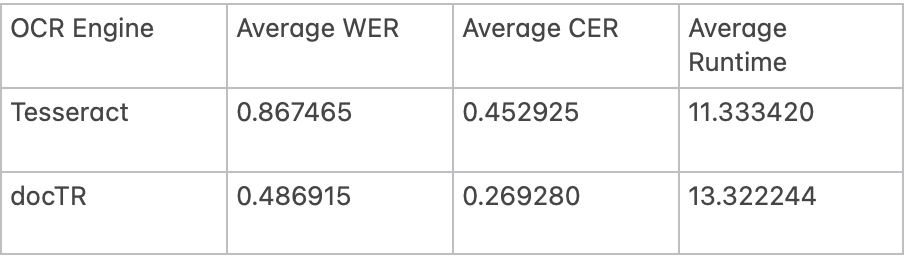



**Metric Definitions:**

WER (Word Error Rate): Measures how many words differ from the ground truth.
Example:
Ground truth: “The quick brown fox”
OCR output: “The quick brown”
→ WER = 1 / 4 = 0.25 (25% error)

CER (Character Error Rate): Measures character-level errors.
Example:
Ground truth: “hello”
OCR output: “helo”
→ CER = 1 / 5 = 0.2 (20% error)

**Inferences**

*   docTR has **~44% lower WER and ~41% lower CER than Tesseract.**
*   docTR is only **~18% slower on average than Tesseract**
*   On the positive side, **docTR requires less development effort**, as it internally handles image preprocessing, unlike Tesseract which often needs manual pre-cleaning for optimal performance.

**This is the reason for choosing docTR over tesseract**
















In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from doctr.models import ocr_predictor
from doctr.io import DocumentFile

from PIL import Image

# Initialize once globally (outside function)
model = ocr_predictor(pretrained=True)

  0%|          | 0/65814772 [00:00<?, ?it/s]

  0%|          | 0/63303144 [00:00<?, ?it/s]

In [ ]:
from pdf2image import convert_from_path
def docTR_processing(pdf_path):
  pages = convert_from_path(pdf_path)
  # Convert PDF pages to images
  pages = convert_from_path(pdf_path)
  all_text = []
  doc = DocumentFile.from_pdf(pdf_path)
  #print(f"Number of pages: {len(doc)}")

  # Run OCR
  result = model(doc)
  text = result.render()
  print("Extracted by OCR",text)
  return text

In [ ]:

# ==============================
# Cache setup
# ==============================
CACHE_DIR = f"{SAVE_DIR}/cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def cache_result(func):
    def wrapper(*args, **kwargs):
        key_data = str(args) + str(kwargs)
        key = hashlib.md5(key_data.encode()).hexdigest()
        path = os.path.join(CACHE_DIR, f"{func.__name__}_{key}.pkl")
        if os.path.exists(path):
            with open(path, "rb") as f:
                return pickle.load(f)
        result = func(*args, **kwargs)
        with open(path, "wb") as f:
            pickle.dump(result, f)
        return result
    return wrapper


@cache_result
def classify_document_type_cached(text):
    return classify_document_type(text)


@cache_result
def summarize_text_cached(text):
    return summarize_text(text)


# ==============================
# Batched boundary detection
# ==============================
def batch_detect_document_boundaries(page_summaries: List[str]) -> List[bool]:
    """
    Batch boundary detection: one LLM call for all adjacent pairs.
    Each pair compared by summarized content, returns True if same document.
    """
    pairs_text = []
    for i in range(len(page_summaries) - 1):
        prev_summary = page_summaries[i]
        curr_summary = page_summaries[i + 1]
        pairs_text.append(f"{i+1}. Prev: {prev_summary}\nCurr: {curr_summary}")

    prompt = f"""
You are a document boundary detection agent.
For each numbered pair, answer "Yes" if both pages belong to the same document, or "No" if they do not.
The possible document types are:
    - Resume: CV, professional profile, work history
    - Contract: Legal agreement, terms and conditions, service agreement
    - Mortgage Contract: Home loan agreement, mortgage terms, property financing
    - Invoice: Bill, payment request, financial statement
    - Pay Slip: Salary statement, wage slip, earnings statement
    - Lender Fee Sheet: Detailed list of loan fees, lender charges, closing costs
    - Land Deed: Property deed, title document, ownership certificate
    - Bank Statement: Account statement, transaction history
    - Tax Document: W2, 1099, tax return, tax form
    - Insurance: Insurance policy, coverage document
    - Report: Analysis, research document, findings
    - Letter: Correspondence, memo, communication
    - Form: Application, questionnaire, data entry form
    - ID Document: Driver's license, passport, identification
    - Medical: Medical report, prescription, health record
    - Other: Doesn't fit other categories

Here are the pairs of summaries:

{chr(10).join(pairs_text)}

Example input:
1. Prev: John Doe's payslip for July with salary details
   Curr: John Doe's payslip for August with salary details
2. Prev: John Doe's payslip for August with salary details
   Curr: Contract agreement between John Doe and XYZ Corp

Example output:
Yes
No

Return one Yes/No answer for each pair, one per line, in order.
    """

    try:
        response = llm.complete(prompt)
        lines = [l.strip().lower() for l in response.text.splitlines() if l.strip()]
        results = []
        for l in lines:
            results.append(l.startswith("yes"))
        while len(results) < len(page_summaries) - 1:
            results.append(True)  # default fallback
        return results[: len(page_summaries) - 1]
    except Exception as e:
        print(f"Batch boundary detection error: {e}")
        return [True] * (len(page_summaries) - 1)


# ==============================
# Main extraction and analysis
# ==============================
def extract_and_analyze_pdf(pdf_file) -> Tuple[List[PageInfo], List[LogicalDocument]]:
    """
    Optimized version with caching and batched boundary detection.
    Only classifies when a true document boundary is found.
    """
    print("📖 Starting PDF extraction and analysis...")

    # Load PDF in a unified way
    if isinstance(pdf_file, dict) and "content" in pdf_file:
        doc = fitz.open(stream=pdf_file["content"], filetype="pdf")
    elif hasattr(pdf_file, "read"):
        doc = fitz.open(stream=pdf_file.read(), filetype="pdf")
    else:
        doc = fitz.open(pdf_file)

    pages_info = []
    for i, page in enumerate(doc):
        text = page.get_text()
        if not text.strip():
            print(f"  Page {i}: No text found, attempting OCR...")
            try:
                text = docTR_processing(pdf_file)
                print(f"  Page {i}: OCR extracted {len(text)} characters")
            except Exception as e:
                print(f"  Page {i}: OCR failed - {e}")
                text = ""
        pages_info.append(PageInfo(page_num=i, text=text))
    doc.close()

    if not pages_info:
        raise ValueError("No text could be extracted from PDF")

    print(f"✅ Extracted {len(pages_info)} pages")

    # Summarization
    print("🧠 Generating summaries...")
    page_summaries = [summarize_text_cached(p.text) for p in pages_info]

    # Batched boundary detection
    print("📏 Performing boundary detection (batched)...")
    boundaries = batch_detect_document_boundaries(page_summaries)

    # Grouping and classification
    print("🧩 Building logical document groups...")
    logical_docs = []
    doc_counter = 0

    current_doc_pages = [pages_info[0]]
    current_doc_type = classify_document_type_cached(pages_info[0].text)
    pages_info[0].doc_type = current_doc_type
    pages_info[0].page_in_doc = 0

    for i in range(1, len(pages_info)):
        same_doc = boundaries[i - 1]
        if same_doc:
            pages_info[i].doc_type = current_doc_type
            pages_info[i].page_in_doc = len(current_doc_pages)
            current_doc_pages.append(pages_info[i])
        else:
            # Save current block
            logical_docs.append(
                LogicalDocument(
                    doc_id=f"doc_{doc_counter}",
                    doc_type=current_doc_type,
                    page_start=current_doc_pages[0].page_num,
                    page_end=current_doc_pages[-1].page_num,
                    text="\n\n".join(p.text for p in current_doc_pages),
                )
            )
            doc_counter += 1

            # New block classification only once
            current_doc_type = classify_document_type_cached(pages_info[i].text)
            pages_info[i].doc_type = current_doc_type
            pages_info[i].page_in_doc = 0
            current_doc_pages = [pages_info[i]]
            print(f"  ✳️ New document detected at page {i}: {current_doc_type}")

    # Final group
    if current_doc_pages:
        logical_docs.append(
            LogicalDocument(
                doc_id=f"doc_{doc_counter}",
                doc_type=current_doc_type,
                page_start=current_doc_pages[0].page_num,
                page_end=current_doc_pages[-1].page_num,
                text="\n\n".join(p.text for p in current_doc_pages),
            )
        )

    print(f"✅ Identified {len(logical_docs)} logical documents")
    for ld in logical_docs:
        print(f"   - {ld.doc_type}: Pages {ld.page_start}-{ld.page_end}")

    return pages_info, logical_docs


# **Unit tests: logical_docs, classify_document_type() and detect_document_boundary(), extract_and_analyze_pdf()**

In [ ]:
#Unit test for scanned PDF
pdf_path = "resume.pdf"
pages_info, logical_docs = extract_and_analyze_pdf(pdf_path)
# for page in pages_info:
#     #print(page.text[:200])  # preview first 200 chars
#     classify_document_type(page.text)
# for page in pages_info:
#     if(page.page_num != 0):
#         print(page.page_num)
#         print(detect_document_boundary(pages_info[page.page_num-1].text, page.text))


📖 Starting PDF extraction and analysis...
  Page 0: No text found, attempting OCR...
Extracted by OCR PRINCIPALL INVESTIGATON/PROGRANO DIRECTOR (Last, first, middle): King.MichaelP.
214-76-1903.
Give the following information for the BIOGRAPHICAL key personnel and SKETCH
investigator/program director. Photocopy consultants this and collahorators. for
Begin with the principal
NAME
page each peison.
Yasuyuki Tokunaga, M.D.
IPOSTTIONITILE
Postdoctoral Research Fellow
EDUCATION(Begin with baccalaureate orother thtalanokusimatechscation.
I
Untepenundanagnanadanhual
Yamaguchi University INSTITUTIONANDI School LOCATION of
DEGREE CONFERRED YEAR
Yamaguchi, Japan
Medicine,
I M.D.
1986
I Medicine HELDOESTUDY
RESEARCH AND PROFESSIONAL EXPERIENCE:
experience, development and honors. Key personnel include the Concluding with present position, list, in
in some or execution of
Key personnei principal investigator and any other individuals chronological order, previous
projects will include Indrtint at

In [ ]:
#Unit test for digital PDFs
# pdf_path = "Blob File Sample.pdf"
# pages_info, logical_docs = extract_and_analyze_pdf(pdf_path)

# for page in pages_info:
#     print(page)
#     print(page.text[:200])  # preview first 200 chars

# for doc in logical_docs:
#     print(doc.page_start, doc.page_end)
#     print(doc.doc_type)
#     # preview first 200 chars

# **Intelligent Chunking with Metadata Preservation**

In [ ]:
def chunk_document_with_metadata(logical_doc: LogicalDocument,
                                chunk_size: int = 500,
                                overlap: int = 100) -> List[ChunkMetadata]:
    """
    Chunk a logical document while preserving rich metadata.
    Uses sliding window with overlap for better context.
    """
    chunks_metadata = []
    words = logical_doc.text.split()

    if len(words) <= chunk_size:
        # Document is small enough to be a single chunk
        chunk_meta = ChunkMetadata(
            chunk_id=f"{logical_doc.doc_id}_chunk_0",
            doc_id=logical_doc.doc_id,
            doc_type=logical_doc.doc_type,
            chunk_index=0,
            page_start=logical_doc.page_start,
            page_end=logical_doc.page_end,
            text=logical_doc.text
        )
        chunks_metadata.append(chunk_meta)
    else:
        # Create overlapping chunks
        stride = chunk_size - overlap
        for i, start_idx in enumerate(range(0, len(words), stride)):
            end_idx = min(start_idx + chunk_size, len(words))
            chunk_text = ' '.join(words[start_idx:end_idx])

            # Calculate which pages this chunk spans
            # (simplified - in production, track more precisely)
            chunk_position = start_idx / len(words)
            page_range = logical_doc.page_end - logical_doc.page_start
            relative_page = int(chunk_position * page_range)
            chunk_page_start = logical_doc.page_start + relative_page
            chunk_page_end = min(chunk_page_start + 1, logical_doc.page_end)

            chunk_meta = ChunkMetadata(
                chunk_id=f"{logical_doc.doc_id}_chunk_{i}",
                doc_id=logical_doc.doc_id,
                doc_type=logical_doc.doc_type,
                chunk_index=i,
                page_start=chunk_page_start,
                page_end=chunk_page_end,
                text=chunk_text
            )
            chunks_metadata.append(chunk_meta)

            if end_idx >= len(words):
                break

    return chunks_metadata

def chunk_with_llama_index(logical_doc: LogicalDocument) -> List[Document]:
    """
    Alternative: Use LlamaIndex's advanced chunking with metadata.
    """
    # Create LlamaIndex document with metadata
    doc = Document(
        text=logical_doc.text,
        metadata={
            "doc_id": logical_doc.doc_id,
            "doc_type": logical_doc.doc_type,
            "page_start": logical_doc.page_start,
            "page_end": logical_doc.page_end,
            "source": f"{logical_doc.doc_type}_document"
        }
    )

    # Use LlamaIndex's sentence splitter for better chunking
    splitter = SentenceSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        paragraph_separator="\n\n",
        separator=" ",
    )

    # Create nodes (chunks) from document
    nodes = splitter.get_nodes_from_documents([doc])

    # Convert to our ChunkMetadata format for consistency
    chunks_metadata = []
    for i, node in enumerate(nodes):
        chunk_meta = ChunkMetadata(
            chunk_id=f"{logical_doc.doc_id}_chunk_{i}",
            doc_id=logical_doc.doc_id,
            doc_type=logical_doc.doc_type,
            chunk_index=i,
            page_start=node.metadata.get("page_start", logical_doc.page_start),
            page_end=node.metadata.get("page_end", logical_doc.page_end),
            text=node.text
        )
        chunks_metadata.append(chunk_meta)

    return chunks_metadata


def chunk_with_semantic_splitter(logical_doc: LogicalDocument,
                                 breakpoint_percentile_threshold: int = 90,
                                 buffer_size: int = 2) -> List[ChunkMetadata]:
    """
    Chunk a logical document using semantic splitting (meaning-based).
    Returns a list of ChunkMetadata.
    """
    # Create a LlamaIndex-style Document with metadata
    doc = Document(
        text=logical_doc.text,
        metadata={
            "doc_id": logical_doc.doc_id,
            "doc_type": logical_doc.doc_type,
            "page_start": logical_doc.page_start,
            "page_end": logical_doc.page_end,
            "source": f"{logical_doc.doc_type}_document"
        }
    )

    #  Initialize semantic splitter
    semantic_splitter = SemanticSplitterNodeParser(embed_model=embed_model,buffer_size=buffer_size,
        breakpoint_percentile_threshold=breakpoint_percentile_threshold
    )

    # Get semantic nodes (chunks)
    nodes = semantic_splitter.get_nodes_from_documents([doc])

    #  Convert nodes to ChunkMetadata for consistency
    chunks = []
    for i, node in enumerate(nodes):
        chunk_meta = ChunkMetadata(
            chunk_id=f"{logical_doc.doc_id}_chunk_{i}",
            doc_id=logical_doc.doc_id,
            doc_type=logical_doc.doc_type,
            chunk_index=i,
            page_start=node.metadata.get("page_start", logical_doc.page_start),
            page_end=node.metadata.get("page_end", logical_doc.page_end),
            text=node.text
        )
        chunks.append(chunk_meta)

    print(f"📄 {logical_doc.doc_type}: Created {len(chunks)} semantic chunks")
    return chunks


def process_all_documents(logical_docs: List[LogicalDocument],
                         use_llama_index: bool = False, use_semantic: bool=False) -> List[ChunkMetadata]:
    """
    Process all logical documents into chunks with metadata.
    Can use either custom or LlamaIndex chunking.
    """
    all_chunks = []

    for logical_doc in logical_docs:
        if use_llama_index:
            chunks = chunk_with_llama_index(logical_doc)
        elif use_semantic:
            chunks = chunk_with_semantic_splitter(logical_doc)
        else:
            chunks = chunk_document_with_metadata(logical_doc)

        logical_doc.chunks = chunks  # Store reference
        all_chunks.extend(chunks)
        print(f"📄 {logical_doc.doc_type}: Created {len(chunks)} chunks")

    return all_chunks

# **Unit test: process_all_documents()**

In [ ]:
chunks = process_all_documents(logical_docs, use_semantic=True)

for chunk in chunks:
    print(f"\n🧩 Chunk ID: {chunk.chunk_id}")
    print(f"📄 Doc Type: {chunk.doc_type}")
    print(f"📑 Pages: {chunk.page_start}-{chunk.page_end}")
    print(f"📝 Text (first 150 chars): {chunk.text[:150]}...")


# **Query Routing and Intelligent Retrieval**

In [ ]:
#normalize score to combine semantic and bm25(keyword) node techniques
def normalize_scores_minmax(scores):
      min_score = min(scores) if scores else 0.0
      max_score = max(scores) if scores else 1.0
      range_score = max_score - min_score
      if range_score == 0:
          return [1.0 for _ in scores]
      return [(s - min_score) / range_score for s in scores]


In [ ]:
#Nodes returned by BM25 need to be converted to the defined datastructure: chunkmetadata
def node_to_chunkmetadata(node):
    metadata = node.metadata
    # Note: embeddings likely need special handling if stored as list
    embedding = None
    if hasattr(node, 'embedding') and node.embedding is not None:
        if isinstance(node.embedding, list):
          embedding = np.array(node.embedding, dtype=np.float32)
        elif isinstance(node.embedding, np.ndarray):
          embedding = node.embedding

    return ChunkMetadata(
        chunk_id=metadata.get("chunk_id", ""),
        doc_id=metadata.get("doc_id", ""),
        doc_type=metadata.get("doc_type", ""),
        chunk_index=metadata.get("chunk_index", 0),
        page_start=metadata.get("page_start", 0),
        page_end=metadata.get("page_end", 0),
        text=node.text,
        embedding=embedding
      )


In [ ]:
def chunkmetadata_to_node(chunk):
  return TextNode(
            text=chunk.text,
            metadata={
                "chunk_id": chunk.chunk_id,
                "doc_id": chunk.doc_id,
                "doc_type": chunk.doc_type,
                "chunk_index": chunk.chunk_index,
                "page_start": chunk.page_start,
                "page_end": chunk.page_end,
            }
    )

In [ ]:

def predict_query_document_type(query: str) -> Tuple[str, float]:
    """
    Predict which document type is most likely to contain the answer.
    Returns predicted type and confidence score.
    """
    prompt = f"""
    Analyze this query and predict which document type would most likely contain the answer.

    Query: "{query}"

    Choose the MOST LIKELY type from:
    - Resume: Career, experience, education, skills, employment history
    - Contract: Terms, agreements, obligations, parties, legal terms
    - Mortgage Contract: Home loan, property financing, mortgage terms, interest rates
    - Invoice: Payments, amounts due, billing, charges, invoiced items
    - Pay Slip: Salary, wages, deductions, earnings, pay period
    - Lender Fee Sheet: Loan fees, closing costs, origination fees, lender charges
    - Land Deed: Property ownership, deed information, property description, title
    - Bank Statement: Account balance, transactions, deposits, withdrawals
    - Tax Document: Tax information, W2, 1099, tax returns, tax amounts
    - Insurance: Coverage, policy details, premiums, claims
    - Report: Analysis, findings, conclusions, research data
    - Letter: Communications, requests, notifications, correspondence
    - Form: Applications, submitted data, form fields
    - ID Document: Personal identification, ID numbers, identity verification
    - Medical: Health information, medical conditions, prescriptions
    - Other: General or unclear

    Respond **ONLY** in this exact JSON format:
    {{"type": "DocumentType", "confidence": 0.85}}

     Example outputs:
    {{"type": "Resume", "confidence": 0.92}}
    {{"type": "Contract", "confidence": 0.78}}

    Instructions:
    1.Confidence should be between 0.0 and 1.0
    2.Distinguish similar types carefully. For example:
      - Do NOT classify fee tables as Contract; classify as 'Lender Fee Sheet'.
      - Do NOT classify legal text as Lender Fee Sheet unless it lists fees.
    3.Choose ONLY ONE type from the list above.

    """

    try:
      response = llm.complete(prompt)
      text = response.text.strip()
      #print(text)

      # Try to extract JSON part only
      match = re.search(r'\{.*\}', text, re.DOTALL)
      if match:
        json_str = match.group(0)
        result = json.loads(json_str)
        return result.get("type", "Other"), result.get("confidence", 0.5)
      else:
        raise ValueError("No JSON found in model response")


    except Exception as e:
      print(f"⚠️ Query routing error: {e}")
      return "Other", 0.0



class IntelligentRetriever:
    """
    Advanced retrieval system with metadata filtering and query routing.
    """

    def __init__(self):
        self.index = None
        self.chunks_metadata = []
        self.doc_type_indices = {}  # Separate indices per doc type

    def build_indices(self, chunks_metadata: List[ChunkMetadata]):
        """
        Build FAISS indices with document type segregation.
        """
        print("🔨 Building vector indices...")
        self.chunks_metadata = chunks_metadata

        # Create embeddings for all chunks
        texts = [chunk.text for chunk in chunks_metadata]
        embeddings = np.array(
        [embed_model.get_text_embedding(text) for text in texts],
        dtype="float32"
        )

        # Store embeddings in metadata
        for i, chunk in enumerate(chunks_metadata):
            chunk.embedding = embeddings[i]

        # Build main index
        dim = embeddings.shape[1]
        self.index = faiss.IndexFlatL2(dim)
        self.index.add(embeddings)

        # Build separate indices for each document type
        doc_types = set(chunk.doc_type for chunk in chunks_metadata)
        for doc_type in doc_types:
            type_indices = [i for i, chunk in enumerate(chunks_metadata)
                          if chunk.doc_type == doc_type]
            if type_indices:
                type_embeddings = embeddings[type_indices]
                type_index = faiss.IndexFlatL2(dim)
                type_index.add(type_embeddings)
                self.doc_type_indices[doc_type] = {
                    'index': type_index,
                    'mapping': type_indices  # Maps back to original chunks
                }

        print(f"✅ Indexed {len(chunks_metadata)} chunks across {len(doc_types)} document types")

    def retrieve(self, query: str, k: int = 6, filter_doc_type: Optional[str] = None, auto_route: bool = True):
        # BM25 + Vector (Keyword+ semantic search strategy needs Node type)
        # Convert chunks to Nodes
        chunk_nodes = [chunkmetadata_to_node(chunk) for chunk in self.chunks_metadata]

        #Converts the input query string into a semantic embedding vector
        query_embedding = np.array([embed_model.get_text_embedding(query)], dtype="float32")

        #Performs a nearest neighbor search returning distances and indices, does query routing

        if filter_doc_type and filter_doc_type in self.doc_type_indices:
            type_data = self.doc_type_indices[filter_doc_type]
            D, I = type_data['index'].search(query_embedding, k)
            chunk_indices = [type_data['mapping'][i] for i in I[0]]
            distances = D[0]
        elif auto_route:
            predicted_type, confidence = predict_query_document_type(query)
            print(f"🎯 Query routed to: {predicted_type} (confidence: {confidence:.2f})")
            if confidence > 0.7 and predicted_type in self.doc_type_indices:
                type_data = self.doc_type_indices[predicted_type]
                D, I = type_data['index'].search(query_embedding, k)
                chunk_indices = [type_data['mapping'][i] for i in I[0]]
                distances = D[0]
            else:
                D, I = self.index.search(query_embedding, k)
                chunk_indices = I[0]
                distances = D[0]
        else:
            D, I = self.index.search(query_embedding, k)
            chunk_indices = I[0]
            distances = D[0]

        # Convert distances to similarity scores (inverse)
        max_dist = max(distances) if len(distances) > 0 else 1.0
        sem_scores_raw = [(max_dist - d) / max_dist for d in distances]
        sem_chunks = [(chunk_nodes[i], sem_scores_raw[idx]) for idx, i in enumerate(chunk_indices)]

        # BM25 keyword retrieval
        bm25_retriever = BM25Retriever.from_defaults(nodes=chunk_nodes, similarity_top_k=k)
        key_nodes = bm25_retriever.retrieve(query)
        bm25_scores_raw = [getattr(node, 'score', 1.0) for node in key_nodes]
        key_chunks = list(zip(key_nodes, bm25_scores_raw))

        # Normalize scores independently
        sem_scores = normalize_scores_minmax([score for _, score in sem_chunks])
        bm25_scores = normalize_scores_minmax(bm25_scores_raw)

        # Map normalized scores back
        sem_chunks_norm = [(node, score) for (node, _), score in zip(sem_chunks, sem_scores)]
        key_chunks_norm = [(node, score) for (node, _), score in zip(key_chunks, bm25_scores)]

        ALPHA=0.4
        # Combine by weighted sum
        combined = {}
        for node, score in sem_chunks_norm:
          combined[node.metadata["chunk_id"]] = ALPHA * score
        for node, score in key_chunks_norm:
          existing = combined.get(node.metadata["chunk_id"], 0.0)
          combined[node.metadata["chunk_id"]] = existing + (1 - ALPHA) * score

        # Retrieve final chunks from combined keys and scores
        unique_nodes = []
        seen_ids = set()
        for node in chunk_nodes:
          chunk_id = node.metadata["chunk_id"]
          if chunk_id in combined and chunk_id not in seen_ids:
              unique_nodes.append((node, combined[chunk_id]))
              seen_ids.add(chunk_id)
        # Threshold and sort
        SIMILARITY_THRESHOLD = 0.3
        filtered_results = [(node, score) for node, score in unique_nodes if score >= SIMILARITY_THRESHOLD]
        filtered_results.sort(key=lambda x: x[1], reverse=True)


        if len(filtered_results) == 0:
            print(f"⚠️ No chunks passed similarity threshold ({SIMILARITY_THRESHOLD}). Returning top raw result instead.")
            filtered_results = unique_nodes[:1]

        #Converts the filtered TextNode objects back to your native chunk metadata.
        final_results = [(node_to_chunkmetadata(node), score) for node, score in filtered_results]
        return final_results



# **Unit tests: predict_query_document_type() and Intelligent Retriever: retireve function()**

In [ ]:
#predict_query_document_type("Calculate, how much percentage of the purchase price is the daily interest amount?")

In [ ]:
#predict_query_document_type("What are the origination fees for my loan?")

In [ ]:
query="What is  Yasuyuki Tokunaga's  field of study and institution? "
retriever = IntelligentRetriever()
retriever.build_indices(chunks)

# Step 3: Test retrieval
query = "What is  Yasuyuki Tokunaga's  field of study and institution? "
results = retriever.retrieve(query)

print("\n🔍 Retrieval Results:")
for meta, score in results:
    print(f"- {meta.doc_type} | Score: {score:.2f} | Text: {meta.text[:]}...")


🔨 Building vector indices...
✅ Indexed 5 chunks across 1 document types


DEBUG:bm25s:Building index from IDs objects


🎯 Query routed to: Resume (confidence: 0.95)

🔍 Retrieval Results:
- Resume | Score: 1.00 | Text: Photocopy consultants this and collahorators. for
Begin with the principal
NAME
page each peison.
Yasuyuki Tokunaga, M.D.
IPOSTTIONITILE
Postdoctoral Research Fellow
EDUCATION(Begin with baccalaureate orother thtalanokusimatechscation.
I
Untepenundanagnanadanhual
Yamaguchi University INSTITUTIONANDI School LOCATION of
DEGREE CONFERRED YEAR
Yamaguchi, Japan
Medicine,
I M.D.
1986
I Medicine HELDOESTUDY
RESEARCH AND PROFESSIONAL EXPERIENCE:
experience, development and honors. Key personnel include the Concluding with present position, list, in
in some or execution of
Key personnei principal investigator and any other individuals chronological order, previous
projects will include Indrtint at the masters or typically will include all individuals with
who participate In the
or
doctoral
umploensine
development chronological execution of the project. Include baccalaureate level provided they cont

##  Enhanced Answer Generation with Source Attribution

In [ ]:
def generate_answer_with_sources(query: str,
                                retrieved_chunks: List[Tuple[ChunkMetadata, float]]) -> Dict:
    """
    Generate answer with detailed source attribution.
    """
    if not retrieved_chunks:
        return {
            'answer': "I couldn't find relevant information to answer your question.",
            'sources': [],
            'confidence': 0.0
        }

    # Prepare context from retrieved chunks
    context_parts = []
    sources = []

    for chunk_meta, score in retrieved_chunks:
        context_parts.append(f"[From {chunk_meta.doc_type}, Pages {chunk_meta.page_start}-{chunk_meta.page_end}]")
        context_parts.append(chunk_meta.text)
        context_parts.append("")

        sources.append({
            'doc_type': chunk_meta.doc_type,
            'pages': f"{chunk_meta.page_start}-{chunk_meta.page_end}",
            'relevance': f"{score:.2%}",
            'preview': chunk_meta.text[:100] + "..."
        })

    context = "\n".join(context_parts)

    # Generate answer
    prompt = f"""
    You are a helpful AI assistant. Use the provided context to answer the question.
    Be specific and cite which document type and pages support your answer.

    Context:
    {context}

    Question: {query}

    Example input:
    Context:
    [From Contract, Pages 1-3] The loan term is 30 years.
    [From Contract, Pages 1-3] Interest rate is fixed at 4.25%.

    Question:
    What is the loan term and interest rate?

    Example output:
    The loan term is 30 years and the interest rate is 4.25%, according to the Contract document covering pages 1 to 3.


    Instructions:
  1. Answer ONLY using the information in the provided context.
  2. Cite the supporting document type(s) and page range(s) for each factual statement.
  3. If the context doesn't contain enough information to answer fully, explicitly say so.
  4. Provide a clear, direct, and complete but precise response without adding external knowledge.
  5. Structure your answer logically and in an easy-to-understand manner.

    Answer:
    """

    try:
        response = llm.complete(prompt)
        answer = response.text.strip().split("Question:")[0].strip()


        # Calculate overall confidence based on retrieval scores
        avg_score = sum(s for _, s in retrieved_chunks) / len(retrieved_chunks)

        return {
            'answer': answer,
            'sources': sources,
            'confidence': avg_score,
            'chunks_used': len(retrieved_chunks)
        }
    except Exception as e:
        print(f"Answer generation error: {e}")
        return {
            'answer': f"Error generating answer: {str(e)}",
            'sources': sources,
            'confidence': 0.0
        }

# **Unit test: generate_answer_with_sources()**

In [ ]:
print(generate_answer_with_sources("What is  Yasuyuki Tokunaga's  field of study and institution? ",results))

# **Enhanced Document Store**

In [ ]:
#Managing tokens to ensure that 4098 token limit of Phi-3 LLM is not exceeded
def count_tokens(text: str) -> int:
  """Return token count for text using the Phi-3 tokenizer."""
  return len(TOKENIZER.encode(text, add_special_tokens=False))

In [ ]:
class EnhancedDocumentStore:
    """
    Manages the complete document processing and retrieval pipeline.
    """

    def __init__(self):
        self.pages_info = []
        self.logical_docs = []
        self.chunks_metadata = []
        self.retriever = IntelligentRetriever()
        self.is_ready = False
        self.processing_stats = {}
        self.filename = None

    def process_pdf(self, pdf_file, filename: str = "document.pdf"):
        """
        Complete PDF processing pipeline.
        """
        self.filename = filename
        self.is_ready = False
        start_time = datetime.now()

        try:
            # Extract and analyze PDF
            self.pages_info, self.logical_docs = extract_and_analyze_pdf(pdf_file)

            # Chunk documents with metadata
            self.chunks_metadata = process_all_documents(self.logical_docs,use_semantic=True)

            # Build retrieval indices
            self.retriever.build_indices(self.chunks_metadata)

            # Calculate processing statistics
            process_time = (datetime.now() - start_time).total_seconds()
            self.processing_stats = {
                'filename': filename,
                'total_pages': len(self.pages_info),
                'documents_found': len(self.logical_docs),
                'total_chunks': len(self.chunks_metadata),
                'document_types': list(set(doc.doc_type for doc in self.logical_docs)),
                'processing_time': f"{process_time:.1f}s"
            }

            self.is_ready = True
            return True, self.processing_stats

        except Exception as e:
            return False, {'error': str(e)}

    def query(self, question: str, filter_type: Optional[str] = None,
          auto_route: bool = True, k: int = 4) -> Dict:
      """
      Query the document store safely with exact token counting.
      Automatically selects chunks based on relevance and token limits.
      """
      if not self.is_ready:
          return {
            'answer': "Please upload and process a PDF first.",
            'sources': [],
            'confidence': 0.0
          }

      # Step 1: Retrieve chunks sorted by relevance
      retrieved = self.retriever.retrieve(
        question, k=k * 2,  # retrieve extra in case we need to drop some
        filter_doc_type=filter_type,
        auto_route=auto_route
      )
      retrieved = sorted(retrieved, key=lambda x: x[1], reverse=True)

      # Step 2: Calculate max tokens for context
      OUTPUT_BUFFER = 800  # reserve space for model's answer so that answers are not truncated
      prompt_tokens = count_tokens(question) + 200  # buffer for instructions/prompt
      MAX_TOKENS = 4096 - prompt_tokens-OUTPUT_BUFFER

      # Step 3: Select chunks without exceeding MAX_TOKENS
      selected_chunks = []
      current_tokens = 0
      for chunk_meta, score in retrieved:
          chunk_tokens = count_tokens(chunk_meta.text)
          if current_tokens + chunk_tokens > MAX_TOKENS:
              break
          selected_chunks.append((chunk_meta, score))
          current_tokens += chunk_tokens

      # Optional: Warn if some chunks are skipped
      omitted_chunks = len(retrieved) - len(selected_chunks)

      # Step 4: Generate answer with sources using the safely selected chunks
      result = generate_answer_with_sources(question, selected_chunks)
      result['filter_used'] = filter_type or ('auto' if auto_route else 'none')
      result['chunks_used'] = len(selected_chunks)
      result['chunks_token_count'] = current_tokens
      if omitted_chunks > 0:
          result['warning'] = f"{omitted_chunks} lower-relevance chunk(s) omitted due to token limit."
      print(result)
      return result


    def get_document_structure(self) -> List[Dict]:
        """
        Get the document structure for UI display.
        """
        if not self.logical_docs:
            return []

        structure = []
        for doc in self.logical_docs:
            structure.append({
                'id': doc.doc_id,
                'type': doc.doc_type,
                'pages': f"{doc.page_start + 1}-{doc.page_end + 1}",  # 1-indexed for UI
                'chunks': len(doc.chunks) if doc.chunks else 0,
                'preview': doc.text[:200] + "..." if len(doc.text) > 200 else doc.text
            })

        return structure

# **UI with Gradio**

In [ ]:
# Global store instance
doc_store = EnhancedDocumentStore()

def process_pdf_handler(pdf_file):
    """Handle PDF upload and processing."""
    if pdf_file is None:
        return "⚠️ Please upload a PDF file", None, gr.update(choices=["All"])

    # Process the PDF
    success, stats = doc_store.process_pdf(pdf_file,
                                          filename=getattr(pdf_file, 'name', 'document.pdf'))

    if success:
        # Prepare status message
        status_msg = f"""
        ✅ **Successfully Processed:**
        - 📄 File: {stats['filename']}
        - 📑 Pages: {stats['total_pages']}
        - 📚 Documents Found: {stats['documents_found']}
        - 🧩 Chunks Created: {stats['total_chunks']}
        - 🏷️ Types: {', '.join(stats['document_types'])}
        - ⏱️ Time: {stats['processing_time']}
        """

        # Get document structure for display
        structure = doc_store.get_document_structure()
        structure_display = "\n".join([
            f"• **{doc['type']}** (Pages {doc['pages']}): {doc['chunks']} chunks"
            for doc in structure
        ])

        # Update filter choices
        doc_types = ["All"] + stats['document_types']

        return status_msg, structure_display, gr.update(choices=doc_types, value="All")
    else:
        return f"❌ Error: {stats.get('error', 'Unknown error')}", None, gr.update(choices=["All"])

def chat_handler(message, history, doc_filter, auto_route, num_chunks):
    """Handle chat interactions."""
    if not doc_store.is_ready:
        response = "📚 Please upload and process a PDF document first."
        return history + [[message, response]]

    # Query the document store
    filter_type = None if doc_filter == "All" else doc_filter
    result = doc_store.query(
        message,
        filter_type=filter_type,
        auto_route=auto_route and filter_type is None,
        k=num_chunks
    )

    # Format response with sources
    response = f"{result['answer']}\n\n"

    if result['sources']:
        response += "📍 **Sources:**\n"
        for src in result['sources']:
            response += f"• {src['doc_type']} (Pages {src['pages']}) - Relevance: {src['relevance']}\n"

    response += f"\n*Confidence: {result['confidence']:.1%} | Filter: {result['filter_used']}*"

    return history + [[message, response]]

def create_interface():
    """Create the enhanced Gradio interface with unified single-tab layout."""

    with gr.Blocks(title="Enhanced Document Q&A", theme=gr.themes.Soft()) as demo:
        gr.Markdown("""
        # 🚀 Enhanced Document Q&A System
        ### Intelligent Multi-Document Analysis with Advanced RAG Pipeline
        """)

        with gr.Row():
            # Left side - PDF preview and upload
            with gr.Column(scale=2):
                pdf_input = PDF(
                    label="📄 PDF Document Viewer",
                    interactive=True,
                    height=600
                )

                with gr.Row():
                    process_btn = gr.Button(
                        "🔄 Process Document",
                        variant="primary",
                        size="lg",
                        scale=2
                    )
                    clear_all_btn = gr.Button(
                        "🗑️ Clear All",
                        variant="secondary",
                        size="lg",
                        scale=1
                    )

            # Middle - Document info and settings
            with gr.Column(scale=1):
                gr.Markdown("### 📊 Document Info")
                status_output = gr.Markdown(
                    value="⏳ Waiting for PDF upload..."
                )

                structure_output = gr.Markdown(
                    value="",
                    label="Document Structure"
                )

                gr.Markdown("### ⚙️ Settings")

                doc_filter = gr.Dropdown(
                    choices=["All"],
                    value="All",
                    label="🏷️ Document Type Filter",
                    info="Filter search to specific document type"
                )

                auto_route = gr.Checkbox(
                    value=True,
                    label="🎯 Auto-Route Queries",
                    info="Automatically detect relevant document type"
                )

                num_chunks = gr.Slider(
                    minimum=1,
                    maximum=10,
                    value=4,
                    step=1,
                    label="📊 Chunks to Retrieve"
                )

            # Right side - Chat interface
            with gr.Column(scale=2):
                gr.Markdown("### 💬 Ask Questions")
                chatbot = gr.Chatbot(
                    label="Conversation",
                    height=500,
                    elem_id="chatbot",
                    show_label=False
                )

                with gr.Row():
                    msg_input = gr.Textbox(
                        label="Ask a question",
                        placeholder="e.g., What are the payment terms? What is the total amount?",
                        scale=4,
                        show_label=False
                    )
                    send_btn = gr.Button("📤 Send", scale=1, variant="primary")

                with gr.Row():
                    clear_chat_btn = gr.Button("🗑️ Clear Chat", size="sm", scale=1)
                    example_btn1 = gr.Button("📝 What's the summary?", size="sm", scale=1)
                    example_btn2 = gr.Button("💰 Find amounts", size="sm", scale=1)

        # Status bar at the bottom
        with gr.Row():
            status_bar = gr.Markdown(
                value="**Status:** Ready | **Documents:** 0 | **Chunks:** 0 | **Cache Hits:** 0/0",
                elem_id="status_bar"
            )

        # Event handlers
        def update_status_bar():
            """Update the status bar with current statistics."""
            if doc_store.is_ready:
                stats = doc_store.processing_stats
                cache_rate = 0
                if hasattr(doc_store.retriever, 'total_queries') and doc_store.retriever.total_queries > 0:
                    cache_rate = (doc_store.retriever.cache_hits / doc_store.retriever.total_queries) * 100

                return f"**Status:** ✅ Ready | **Documents:** {stats.get('documents_found', 0)} | **Chunks:** {stats.get('total_chunks', 0)} | **Cache Rate:** {cache_rate:.0f}%"
            return "**Status:** Ready | **Documents:** 0 | **Chunks:** 0 | **Cache Hits:** 0/0"

        def clear_all():
            """Clear everything and reset the interface."""
            global doc_store
            doc_store = EnhancedDocumentStore()
            return (
                None,  # pdf_input
                "⏳ Waiting for PDF upload...",  # status_output
                "",  # structure_output
                gr.update(choices=["All"], value="All"),  # doc_filter
                [],  # chatbot
                "",  # msg_input
                update_status_bar()  # status_bar
            )

        # Process PDF handler with status bar update
        def process_pdf_with_status(pdf_file):
            status, structure, filter_update = process_pdf_handler(pdf_file)
            status_bar_text = update_status_bar()
            return status, structure, filter_update, status_bar_text

        # Chat handler with status bar update
        def chat_with_status(message, history, doc_filter, auto_route, num_chunks):
            new_history = chat_handler(message, history, doc_filter, auto_route, num_chunks)
            status_bar_text = update_status_bar()
            return new_history, status_bar_text

        # Example question handlers
        def ask_summary(history):
            return chat_handler("Can you provide a summary of the main points in this document?",
                              history, doc_filter.value, auto_route.value, num_chunks.value)

        def ask_amounts(history):
            return chat_handler("What are all the monetary amounts or financial figures mentioned?",
                              history, doc_filter.value, auto_route.value, num_chunks.value)

        # Wire up all the events
        process_btn.click(
            fn=process_pdf_with_status,
            inputs=[pdf_input],
            outputs=[status_output, structure_output, doc_filter, status_bar]
        )

        clear_all_btn.click(
            fn=clear_all,
            outputs=[pdf_input, status_output, structure_output, doc_filter,
                    chatbot, msg_input, status_bar]
        )

        # Chat interactions
        msg_input.submit(
            fn=chat_with_status,
            inputs=[msg_input, chatbot, doc_filter, auto_route, num_chunks],
            outputs=[chatbot, status_bar]
        ).then(
            lambda: "",
            outputs=[msg_input]
        )

        send_btn.click(
            fn=chat_with_status,
            inputs=[msg_input, chatbot, doc_filter, auto_route, num_chunks],
            outputs=[chatbot, status_bar]
        ).then(
            lambda: "",
            outputs=[msg_input]
        )

        clear_chat_btn.click(
            lambda: [],
            outputs=[chatbot]
        )

        example_btn1.click(
            fn=ask_summary,
            inputs=[chatbot],
            outputs=[chatbot]
        ).then(
            fn=update_status_bar,
            outputs=[status_bar]
        )

        example_btn2.click(
            fn=ask_amounts,
            inputs=[chatbot],
            outputs=[chatbot]
        ).then(
            fn=update_status_bar,
            outputs=[status_bar]
        )

        # Auto-process when PDF is uploaded
        pdf_input.change(
            fn=process_pdf_with_status,
            inputs=[pdf_input],
            outputs=[status_output, structure_output, doc_filter, status_bar]
        )

    return demo

In [ ]:
demo = create_interface()
demo.launch(share=True, debug=True)

/tmp/ipython-input-2059399910.py:136: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://57a197c294b8f3dc2e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


📖 Starting PDF extraction and analysis...
  Page 0: No text found, attempting OCR...
Extracted by OCR PRINCIPALL INVESTIGATON/PROGRANO DIRECTOR (Last, first, middle): King.MichaelP.
214-76-1903.
Give the following information for the BIOGRAPHICAL key personnel and SKETCH
investigator/program director. Photocopy consultants this and collahorators. for
Begin with the principal
NAME
page each peison.
Yasuyuki Tokunaga, M.D.
IPOSTTIONITILE
Postdoctoral Research Fellow
EDUCATION(Begin with baccalaureate orother thtalanokusimatechscation.
I
Untepenundanagnanadanhual
Yamaguchi University INSTITUTIONANDI School LOCATION of
DEGREE CONFERRED YEAR
Yamaguchi, Japan
Medicine,
I M.D.
1986
I Medicine HELDOESTUDY
RESEARCH AND PROFESSIONAL EXPERIENCE:
experience, development and honors. Key personnel include the Concluding with present position, list, in
in some or execution of
Key personnei principal investigator and any other individuals chronological order, previous
projects will include Indrtint at

DEBUG:bm25s:Building index from IDs objects


🎯 Query routed to: Resume (confidence: 0.95)
{'answer': 'Yasuyuki Tokunaga\'s field of study is Medicine, and he obtained his degree from Yamaguchi University in Japan. This information is found in the "EDUCATION" section of the resume provided on pages 0-0.', 'sources': [{'doc_type': 'Resume', 'pages': '0-0', 'relevance': '100.00%', 'preview': 'Photocopy consultants this and collahorators. for\nBegin with the principal\nNAME\npage each peison.\nYa...'}, {'doc_type': 'Resume', 'pages': '0-0', 'relevance': '92.98%', 'preview': 'Tokunaga, pseudohypoaldosicroniam. Y., Yoshida,\nJ. Pediatrics, submitted.\nfurosemide on a patient wi...'}, {'doc_type': 'Resume', 'pages': '0-0', 'relevance': '40.00%', 'preview': 'PRINCIPALL INVESTIGATON/PROGRANO DIRECTOR (Last, first, middle): King.MichaelP.\n214-76-1903.\nGive th...'}, {'doc_type': 'Resume', 'pages': '0-0', 'relevance': '40.00%', 'preview': '7,\ncoprance\nNeurology\ntype\n(1993). The effect of\n114-116.\n3. ...'}], 'confidence': np.float32(0